## Hydropower Dam Data Exploration

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Load the data
metadata = pd.read_csv('metafile.csv')
data = pd.read_csv('global_dams.csv')

In [11]:
# Check the number of dams/features
data.shape

(7320, 69)

In [6]:
# Look at the names of the features. Below are the names of the benefit/impact metrics 
# based on Rafa's email:
#      - CAP_MCM - Storage capacity (benefit metric for water supply/irrigation dams)
#      - GEN_GWH_YR - Gigawatts generated per year (benefit metric for hydropower dams)
#      - FISH_RATIO - Est. fisheries change as the ratio of fisheries gain / fishereis loss in tonnes
#      - CO2EQ - Est. CO2 emmisions in g/m^2.year
data.columns

Index(['GRAND_ID', 'DAM_NAME', 'MAIN_BASIN', 'SUB_BASIN', 'NEAR_CITY',
       'COUNTRY', 'SEC_CNTRY', 'YEAR', 'REM_YEAR', 'DAM_HGT_M', 'DAM_LEN_M',
       'AREA_SKM', 'CAP_MCM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL',
       'CATCH_SKM', 'USE_IRRI', 'USE_ELEC', 'USE_SUPP', 'USE_FCON', 'USE_RECR',
       'USE_NAVI', 'USE_FISH', 'USE_PCON', 'USE_LIVE', 'USE_OTHR', 'MAIN_USE',
       'LAKE_CTRL', 'LONG_DD', 'LAT_DD', 'COUNTRY_1', 'GDP_capita',
       'Population', 'RES_YLD_TN', 'RES_LSS_TN', 'RES_BAL', 'FISH_RATIO',
       'CO2EQ', 'INSCAP_MW', 'GEN_GWH_YR', 'run_mm_syr', 'inu_pc_umn',
       'sgr_dk_sav', 'clz_cl_smj', 'ari_ix_sav', 'ari_ix_uav', 'glc_cl_smj',
       'pnv_cl_smj', 'wet_cl_smj', 'for_pc_use', 'crp_pc_use', 'pst_pc_use',
       'ire_pc_use', 'gla_pc_use', 'prm_pc_use', 'pac_pc_use', 'fmh_cl_smj',
       'soc_th_uav', 'swc_pc_uyr', 'lit_cl_smj', 'ero_kh_uav', 'pop_ct_usu',
       'ppd_pk_uav', 'urb_pc_use', 'hft_ix_u09', 'hdi_ix_sav', 'LAT_KEY'],
      dtype='object

In [21]:
# Print the number of missing values for each metric
for column in ['CAP_MCM', 'GEN_GWH_YR', 'FISH_RATIO', 'CO2EQ']:
    print("{}: {} NaNs".format(column, data[column].isna().sum()))

CAP_MCM: 9 NaNs
GEN_GWH_YR: 6843 NaNs
FISH_RATIO: 1426 NaNs
CO2EQ: 2507 NaNs


In [66]:
7320 - 6843

477

In [31]:
# Filter for dams where the power benefit and GHG and fisheries impacts are not NA
data_filt = data[(~data['GEN_GWH_YR'].isna()) & 
                 (~data['FISH_RATIO'].isna()) & 
                 (~data['CO2EQ'].isna())].copy()
data_filt.shape

(453, 69)

In [69]:
# Add columns to data_filt for fisheries impact and CO2 emissions per GWH generated
data_filt['CO2_per_GWH'] = data_filt.apply(lambda x: x['CO2EQ']/x['GEN_GWH_YR'], axis=1)
data_filt['FISH_RATIO_per_GWH'] = data_filt.apply(lambda x: (1/x['FISH_RATIO'])/x['GEN_GWH_YR'], axis=1)

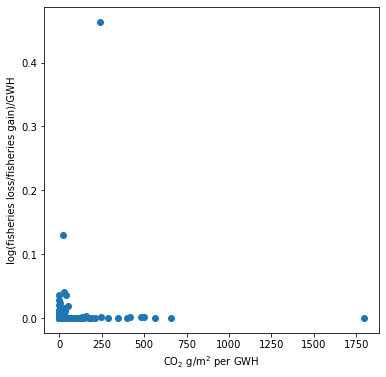

In [70]:
# Plot fisheries gain versus
fig = plt.figure(figsize=(6,6))
plt.scatter(data_filt['CO2_per_GWH'], data_filt['FISH_RATIO_per_GWH'])
plt.xlabel('CO$_2$ g/m$^2$ per GWH')
plt.ylabel('log(fisheries loss/fisheries gain)/GWH')
plt.show()

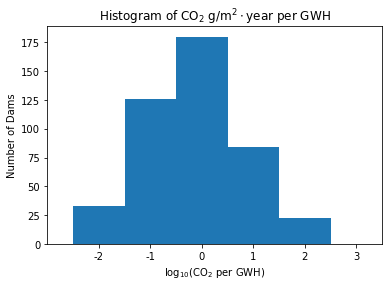

In [65]:
# Plot a histogram of CO2 grams/m^2.year by order of magnitude
plt.hist(np.log10(data_filt['CO2_per_GWH']), bins=np.arange(-2,4,1))
plt.xlabel('$\log_{10}$(CO$_2$ per GWH)')
plt.xticks(ticks=np.arange(-2,4,1) + 0.5, labels=np.arange(-2,4,1))
plt.ylabel('Number of Dams')
plt.xlim([-2.5, 4])
plt.title('Histogram of CO$_2$ g/m$^2 \cdot$year per GWH')
plt.show()